In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
import random
import pandas as pd
import numpy as np

try:
    import stumpy
    from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
except:
    !pip install stumpy
    !pip install sklean
    import stumpy
    from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [65]:
# 1 March 2023 00:00:00 - 6 March 2023 23:59:59
# 518400 seconds between start and end
event_dates = [x for x in range(1677628800, 1678147200)]
len(event_dates)

518400

In [66]:
# Replace with your own Radio Data
radio_list = ['Radio A', 'Radio B', 'Radio C', 'Radio D', 'Radio E', 'Radio F', 'Radio G']
event_radios = [random.choice(radio_list) for x in range(518400)]

In [67]:
# Combine both lists into a tuple
events = tuple(zip(event_dates, event_radios))

In [68]:
# DataFrame of the events
df = pd.DataFrame(events, columns=['date_time', 'radio_type'])

In [69]:
# Use this if the date column is not sorted chronologically
# df.sort_values(by='date_time', inplace=True)

In [70]:
df.head()

,date_time,radio_type
0,1677628800,Radio A
1,1677628801,Radio F
2,1677628802,Radio F
3,1677628803,Radio C
4,1677628804,Radio E


In [71]:
# The radio type column needs to be categorised (switched from strings into numbers)
df['radio_type'] = df['radio_type'].astype('category')
cat_cols = df.select_dtypes(['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

In [72]:
# Once the column is numerical, switch to a float for stumpy/ML usage later
df['radio_type'] = df['radio_type'].astype('float')
df.head()

,date_time,radio_type
0,1677628800,0.0
1,1677628801,5.0
2,1677628802,5.0
3,1677628803,2.0
4,1677628804,4.0


/var/folders/kr/71zr0xyn2c94x6352lt2nqv40000gn/T/ipykernel_12146/3697466939.py:3: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use `date2num(datetime.utcfromtimestamp(e))<.date2num>` instead.
  secs = dates.epoch2num(df['date_time'])


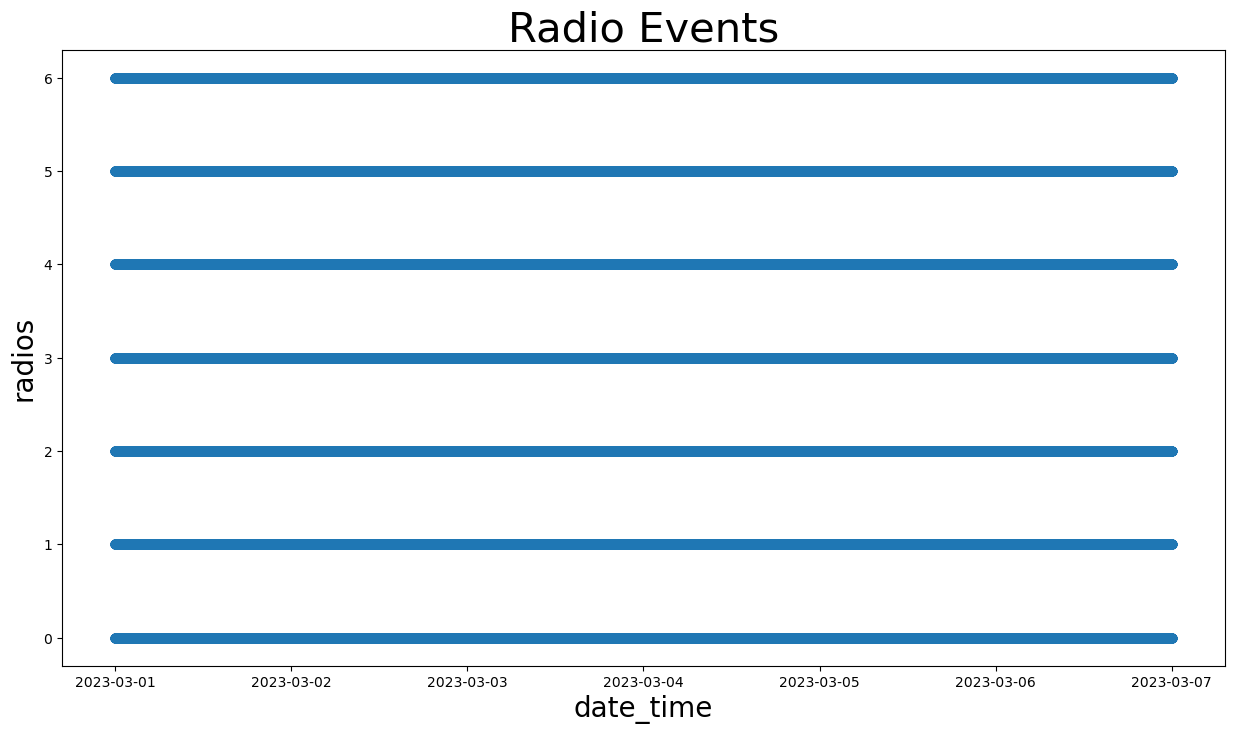

In [88]:
# Initial attempt to plot radio events overtime
# Awful - maybe a line chart instead?
secs = dates.epoch2num(df['date_time'])
fig, ax = plt.subplots()
ax.plot_date(secs, df['radio_type'])
ax.set_title('Radio Events', fontsize='30')
ax.set_xlabel('date_time', fontsize ='20')
ax.set_ylabel('radios', fontsize='20')
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

/var/folders/kr/71zr0xyn2c94x6352lt2nqv40000gn/T/ipykernel_12146/2004149590.py:3: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use `date2num(datetime.utcfromtimestamp(e))<.date2num>` instead.
  secs = dates.epoch2num(df['date_time'])


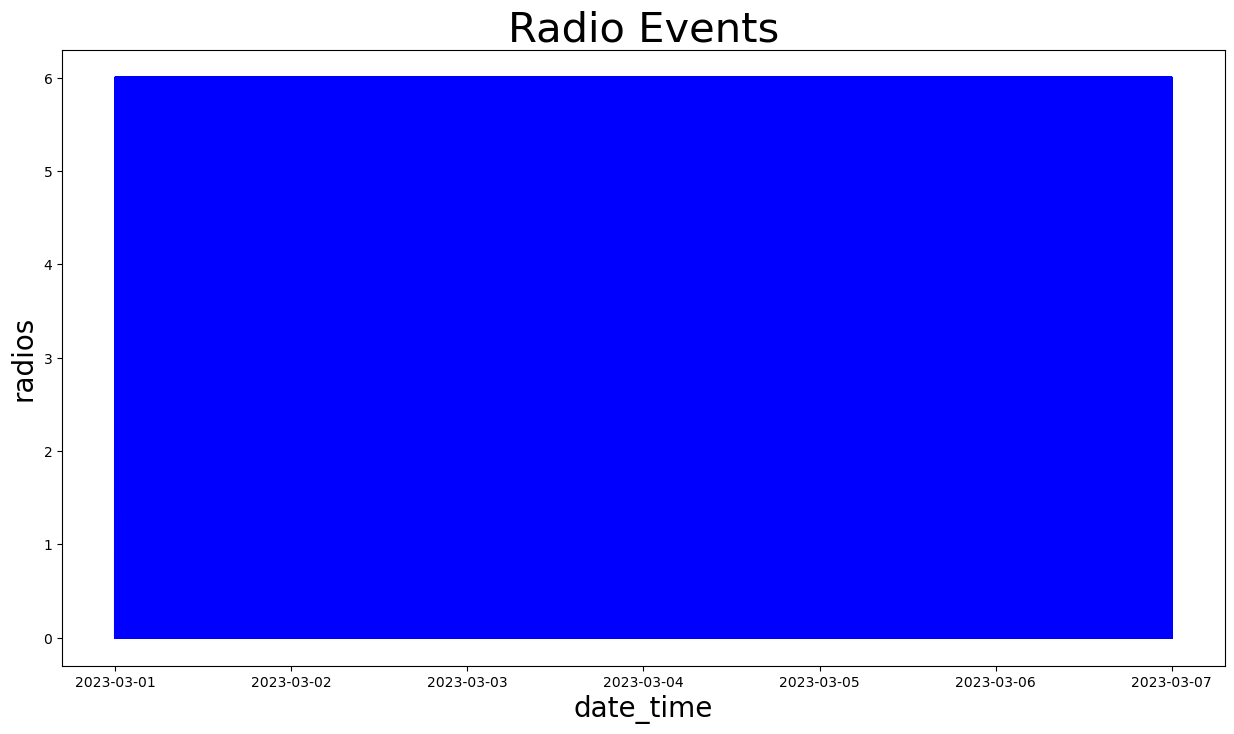

In [89]:
# Also awful - just too much data to fit on one chart and understand visually 
secs = dates.epoch2num(df['date_time'])
fig, ax = plt.subplots()
ax.plot_date(secs, df['radio_type'], 'b-')
ax.set_title('Radio Events', fontsize='30')
ax.set_xlabel('date_time', fontsize ='20')
ax.set_ylabel('radios', fontsize='20')
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [77]:
# m is the number of samples
# e.g. if the data is in seconds/epoch - and I want 15 minute windows then m = 15 * 60 = 900 samples
m = 900
mp = stumpy.stump(df['radio_type'], m)

In [78]:
# Index of the motif pattern in the dataset - still not certain how this witchcraft works its magic
motif_idx = np.argsort(mp[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

The motif is located at index 418333


In [79]:
# Index of the pattern closest to the motif in the dataset
nearest_neighbor_idx = mp[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 231265


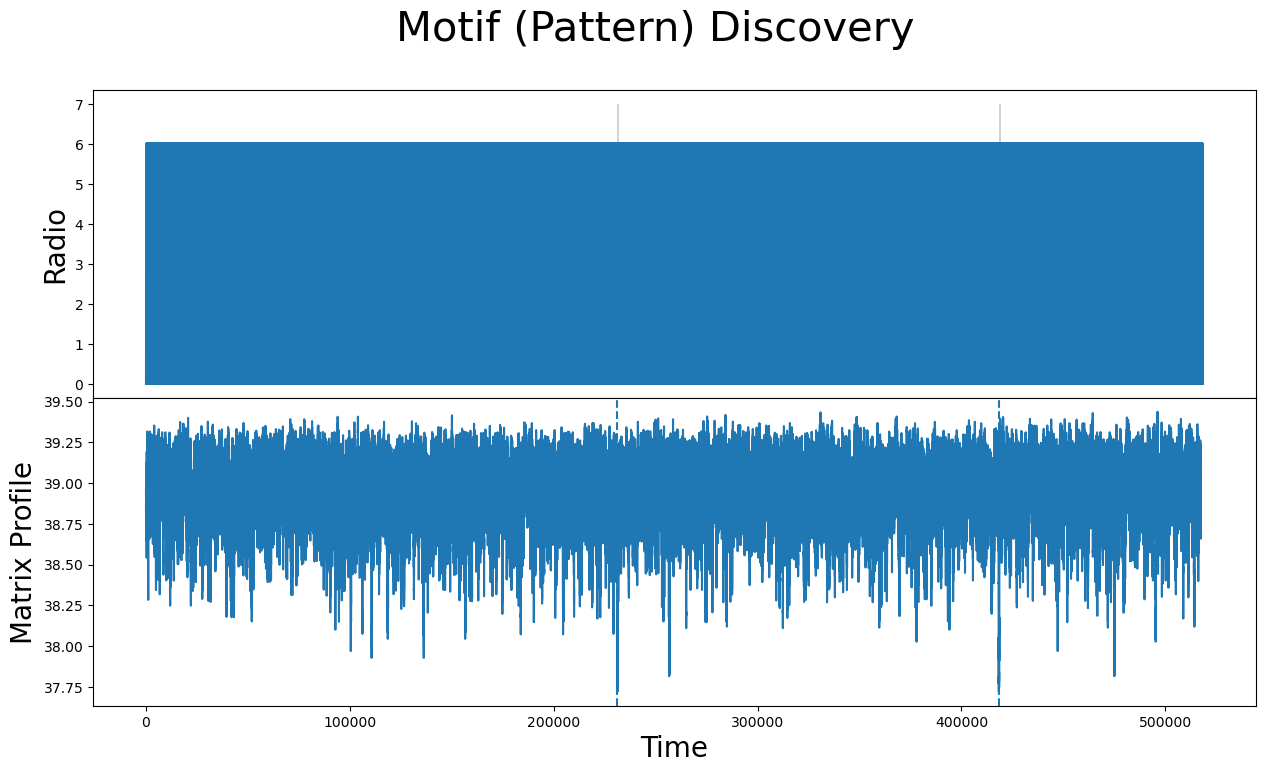

In [81]:
# Plot motif and matrix profile (i.e. Euclidean Distance of each sample)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['radio_type'].values)
axs[0].set_ylabel('Radio', fontsize='20')
# Draw a grey box around the motif - m = width, 7 = height
rect = Rectangle((motif_idx, 0), m, 7, facecolor='lightgrey')
axs[0].add_patch(rect)

# Draw a grey box around the nearest neighbour/pattern - m = width, 7 = height
rect = Rectangle((nearest_neighbor_idx, 0), m, 7, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')

# Draw a dashed line on the motif and nearest neighbour
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [82]:
# Matrix profile score of nearest neighbour - the lower to zero the better
mp[motif_idx, 0]

37.71951071627684

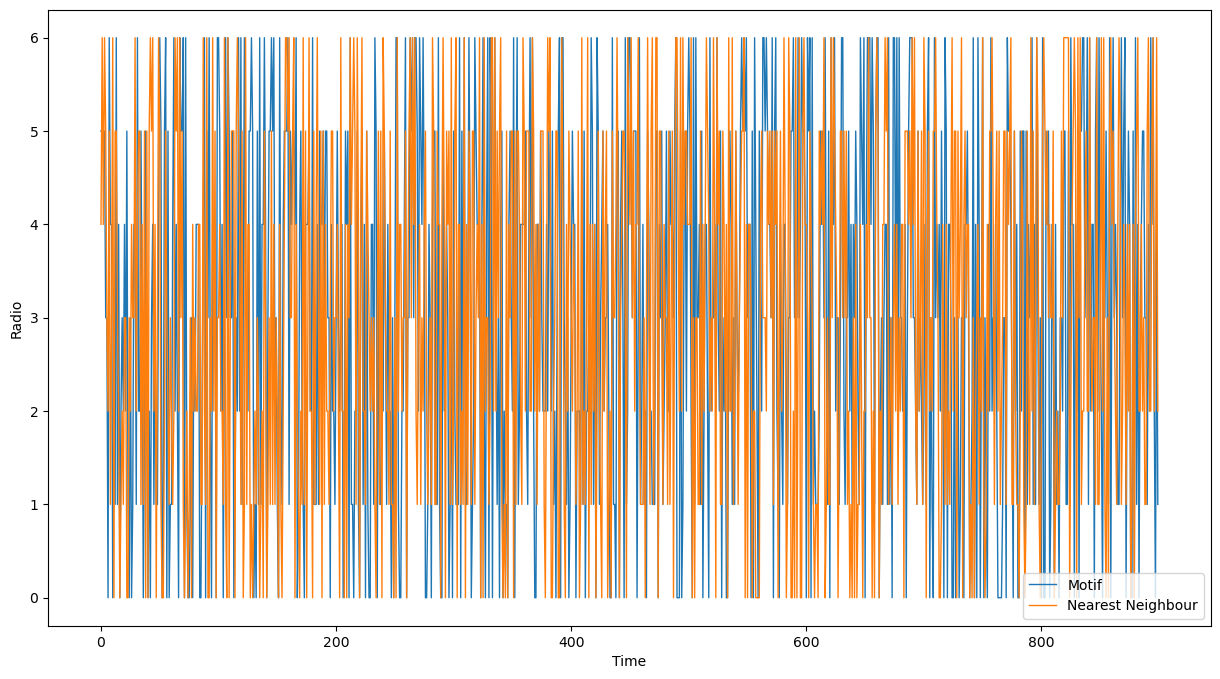

In [85]:
# Plot the motif and nearest neighbour patternm side by side to visually see how close a match stumpy found.
plt.plot(df['radio_type'].iloc[motif_idx: motif_idx + m].values, label='Motif', linewidth=1, markersize=12)
plt.plot(df['radio_type'].iloc[nearest_neighbor_idx: nearest_neighbor_idx + m].values, label='Nearest Neighbour', linewidth=1, markersize=12)
plt.xlabel('Time')
plt.ylabel('Radio')
plt.legend()
plt.show()